**Technical Implementation and Result Report**

Fashion-MNIST Image Classification using ANN and CNN

The purpose of this notebook is to demonstrate and evaluate two supervised deep-learning architectures on Fashion-MNIST dataset. It would compare both **Artificial Neural Network (ANN)** and a **Convolutional Neural Network (CNN)** considering training, accuracy and capability.

**Configuration and Setting Parameters**
The cells below defines random seeds, ouputs and core hyperparameters for all experiments. Allowing saved data and clean structure.

In [53]:
%pip install tensorflow scikit-learn psutil numpy matplotlib pandas seaborn tqdm


In [54]:
import os, random
import numpy as np, tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#device info
print("device:", "GPU" if tf.config.list_physical_devices("GPU") else "CPU")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

#paths
OUT_DIR = "output"
os.makedirs(OUT_DIR, exist_ok=True)
MODEL_DIR = os.path.join(OUT_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
PRED_CSV = os.path.join(OUT_DIR, "predictions.csv")

#hyperparams
BATCH_SIZE = 128
EPOCHS_ANN = 15
EPOCHS_CNN = 25
LR = 0.001
IMG_SIZE = 28
NUM_CLASSES = 10


device: CPU
Num GPUs Available:  0
Num CPUs Available:  1


**Pre-processing and Loading of Dataset**
The Fashion-MNIST dataset contains 70,000 grayscale images where 60,000 would be used for training and the remaining 10,000 would be used for testing across ten clothing categories.
Images would be normalised to zero mean and unit variance.
A 90/10 split of the training data is used for validation.
Normalisation usually improves optimisation stability by preventing large variations in input magnitudes. This leads to faster convergence and a more consistent training performance.

In [55]:
# Load Fashion-MNIST dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt


#Load data and split into training and testing
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

# Normalize values to 0-1 range
train_data = train_data / 255.0
test_data = test_data / 255.0

# split into validation set and training
val_size = int(len(train_data) * 0.1)
val_data = train_data[:val_size]
val_labels = train_labels[:val_size]

train_data = train_data[val_size:]
train_labels = train_labels[val_size:]

print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)

train_data shape: (54000, 28, 28)
train_labels shape: (54000,)
val_data shape: (6000, 28, 28)
val_labels shape: (6000,)
test_data shape: (10000, 28, 28)
test_labels shape: (10000,)


**Artificial Neural Network (ANN)**

The ANN flattens each 28x28 grayscale image into a 784-element feature vector and processes it through fully connected dense layers. ReLU activations then introduce non-linearity, while dropout regularization reduces overfitting. Although this model ignores the spatial structure of the images, it compliments by providing a useful performance baseline for comparison with the CNN.



In [56]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, regularizers

#flatten images
train_data_ann= train_data.reshape((train_data.shape[0], 28*28))
val_data_ann= val_data.reshape((val_data.shape[0], 28*28))
test_data_ann= test_data.reshape((test_data.shape[0], 28*28))

#Buiding the ANN model
ann_model = models.Sequential(
    [
        layers.Input(shape=(28*28,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ]
)
ann_model.summary()



Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,762 (948.29 KB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training (ANN)**

The training of ANN models is done with **Cross-Entropy Loss** for comparing the difference between predicted and actual class probabilities. The **Adam optimiser** updates the network weights during training. It is trained for 15 epochs with validation accuracy measured at the end to track performance and monitor overfitting

In [57]:
from tensorflow.keras.optimizers import Adam

#compilation of ANN model
ann_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#training of ANN model
history = ann_model.fit(train_data_ann, train_labels, epochs=EPOCHS_ANN,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_data_ann, val_labels),
                    verbose=2)
#Evaluate ANN Model
test_loss, test_acc = ann_model.evaluate(test_data_ann, test_labels, verbose=2)
print("Test accuracy:", test_acc)



Epoch 1/15
422/422 - 16s - 38ms/step - accuracy: 0.7599 - loss: 0.6647 - val_accuracy: 0.8378 - val_loss: 0.4372
Epoch 2/15
422/422 - 9s - 22ms/step - accuracy: 0.8379 - loss: 0.4457 - val_accuracy: 0.8608 - val_loss: 0.3827
Epoch 3/15
422/422 - 5s - 11ms/step - accuracy: 0.8535 - loss: 0.4023 - val_accuracy: 0.8675 - val_loss: 0.3623
Epoch 4/15
422/422 - 3s - 8ms/step - accuracy: 0.8621 - loss: 0.3787 - val_accuracy: 0.8713 - val_loss: 0.3532
Epoch 5/15
422/422 - 3s - 8ms/step - accuracy: 0.8673 - loss: 0.3631 - val_accuracy: 0.8740 - val_loss: 0.3392
Epoch 6/15
422/422 - 5s - 11ms/step - accuracy: 0.8707 - loss: 0.3508 - val_accuracy: 0.8750 - val_loss: 0.3359
Epoch 7/15
422/422 - 3s - 7ms/step - accuracy: 0.8761 - loss: 0.3378 - val_accuracy: 0.8780 - val_loss: 0.3375
Epoch 8/15
422/422 - 3s - 7ms/step - accuracy: 0.8775 - loss: 0.3330 - val_accuracy: 0.8790 - val_loss: 0.3268
Epoch 9/15
422/422 - 4s - 10ms/step - accuracy: 0.8822 - loss: 0.3198 - val_accuracy: 0.8790 - val_loss: 0.

**Convolutional Neural Network (CNN)**

The CNN introduces convolution and pooling layers to reduce spatial dimensions in the image data
It captures local patterns like edges and detects features irrespective of location in image.


In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reshape CNN data
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_data_cnn = train_data.reshape((train_data.shape[0], 28,28,1))
val_data_cnn = val_data.reshape((val_data.shape[0], 28,28,1))
test_data_cnn = test_data.reshape((test_data.shape[0], 28,28,1))

#Implementation of Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
  )

datagen.fit(train_data_cnn)

#Building the CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

cnn_model.summary()



Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training (CNN)**

The training of CNN models is done with Cross-Entropy Loss for comparing the difference between predicted and actual class probabilities. The Adam optimiser updates the network weights during training. It is trained for 25 epochs with validation accuracy measured at the end to track performance and monitor overfitting

In [59]:
from tensorflow.keras.optimizers import Adam


#Compilation of CNN model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#Training of CNN model
history_cnn = cnn_model.fit(
    datagen.flow(train_data_cnn, train_labels, batch_size=BATCH_SIZE),
    validation_data=(val_data_cnn, val_labels),
    epochs= EPOCHS_CNN,
    verbose=2
)

#Evaluate CNN model
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_data_cnn, test_labels, verbose=2)
print("\n✅ CNN Test Accuracy:", test_acc_cnn)

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


422/422 - 57s - 135ms/step - accuracy: 0.6865 - loss: 0.8466 - val_accuracy: 0.7853 - val_loss: 0.5460
Epoch 2/25
422/422 - 59s - 140ms/step - accuracy: 0.7744 - loss: 0.5964 - val_accuracy: 0.8327 - val_loss: 0.4448
Epoch 3/25
422/422 - 55s - 130ms/step - accuracy: 0.7977 - loss: 0.5377 - val_accuracy: 0.8420 - val_loss: 0.4203
Epoch 4/25
422/422 - 55s - 129ms/step - accuracy: 0.8129 - loss: 0.4950 - val_accuracy: 0.8390 - val_loss: 0.4136
Epoch 5/25
422/422 - 82s - 194ms/step - accuracy: 0.8288 - loss: 0.4607 - val_accuracy: 0.8635 - val_loss: 0.3695
Epoch 6/25
422/422 - 56s - 132ms/step - accuracy: 0.8352 - loss: 0.4384 - val_accuracy: 0.8767 - val_loss: 0.3253
Epoch 7/25
422/422 - 56s - 132ms/step - accuracy: 0.8444 - loss: 0.4160 - val_accuracy: 0.8697 - val_loss: 0.3437
Epoch 8/25
422/422 - 56s - 132ms/step - accuracy: 0.8514 - loss: 0.4002 - val_accuracy: 0.8787 - val_loss: 0.3219
Epoch 9/25
422/422 - 54s - 129ms/step - accuracy: 0.8571 - loss: 0.3864 - val_accuracy: 0.8865 - va

**Performance Curves**
The performance of both models would be plotted using training and validation accuracy/loss curves. It is noticed a steady reduction in loss and increase in accuracy. CNN generally shows smoother convergence and higher validation accuracy compared to ANN.

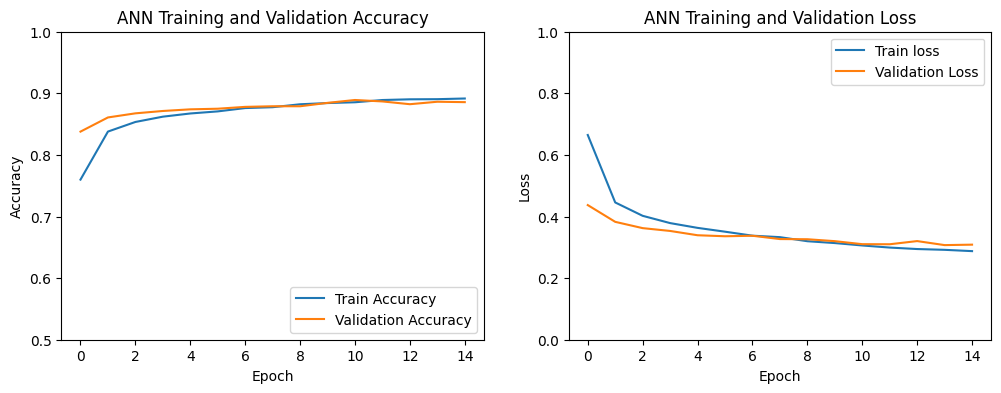

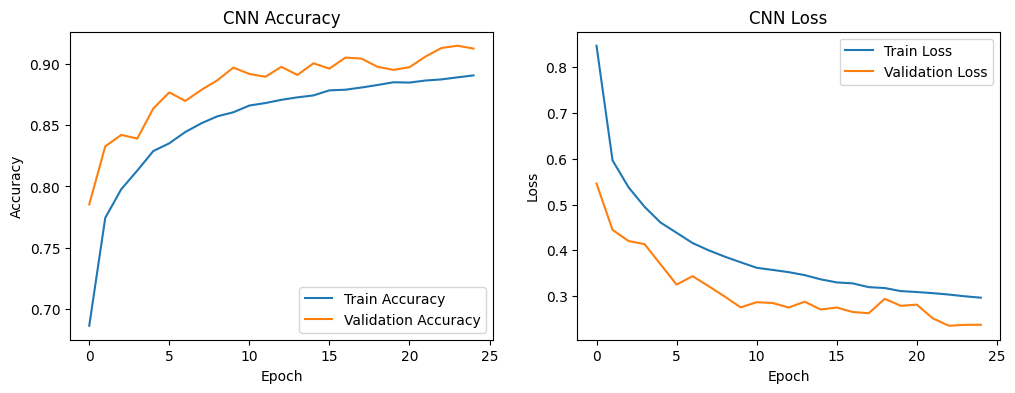

In [60]:
#plot accuracy and loss curves for ANN
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('ANN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('ANN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()

#Plot accuracy and loss for CNN
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()



313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


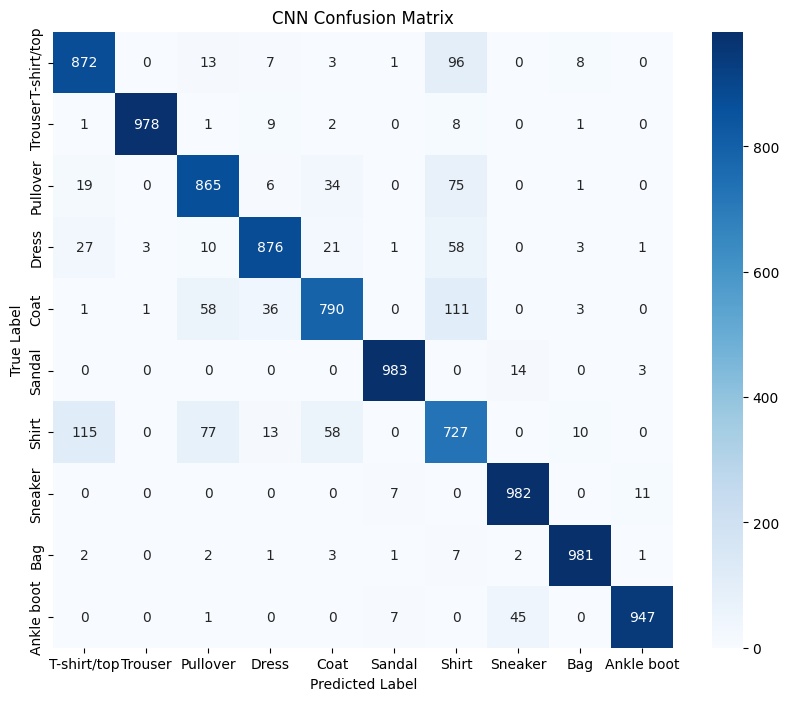

              precision    recall  f1-score   support

 T-shirt/top     0.8409    0.8720    0.8562      1000
     Trouser     0.9959    0.9780    0.9869      1000
    Pullover     0.8423    0.8650    0.8535      1000
       Dress     0.9241    0.8760    0.8994      1000
        Coat     0.8672    0.7900    0.8268      1000
      Sandal     0.9830    0.9830    0.9830      1000
       Shirt     0.6719    0.7270    0.6984      1000
     Sneaker     0.9415    0.9820    0.9613      1000
         Bag     0.9742    0.9810    0.9776      1000
  Ankle boot     0.9834    0.9470    0.9648      1000

    accuracy                         0.9001     10000
   macro avg     0.9024    0.9001    0.9008     10000
weighted avg     0.9024    0.9001    0.9008     10000



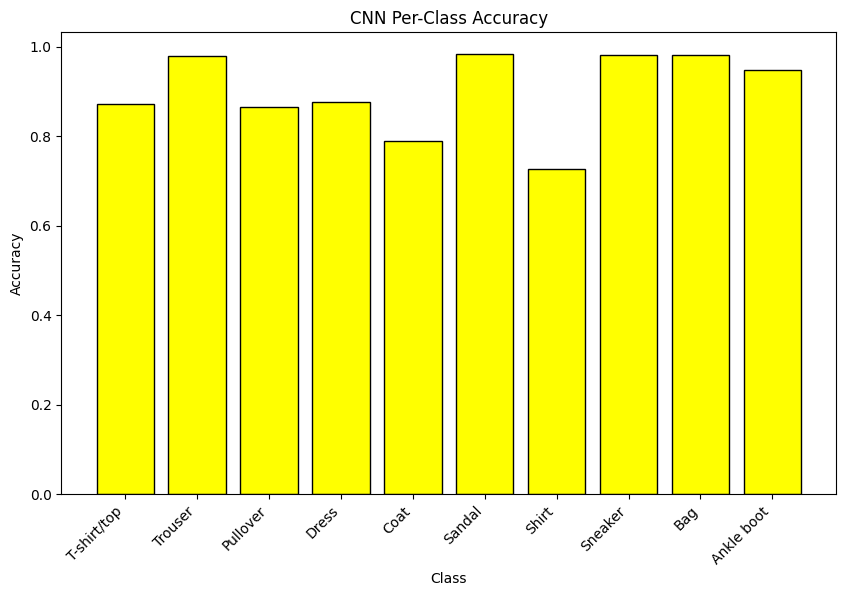

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


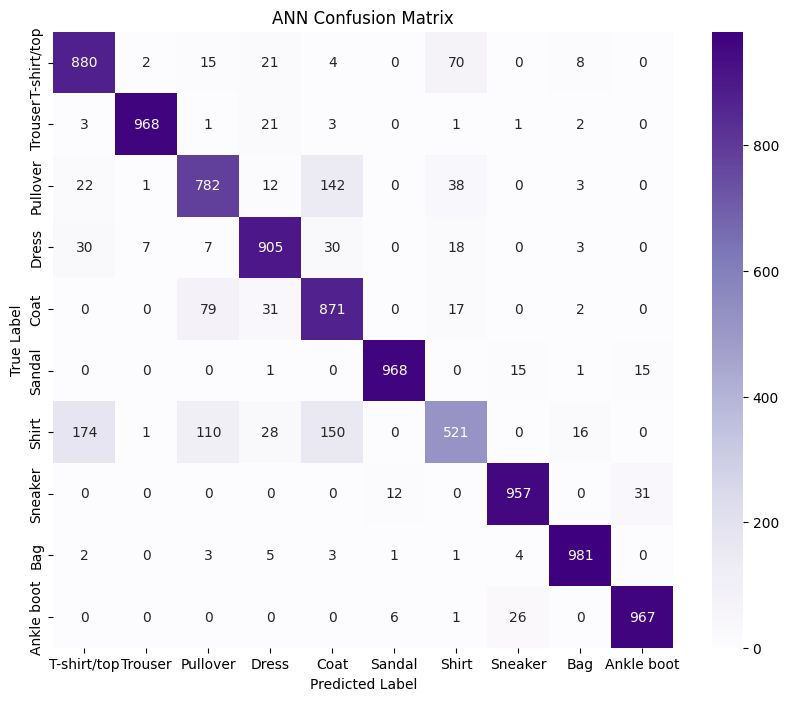

              precision    recall  f1-score   support

 T-shirt/top     0.7921    0.8800    0.8337      1000
     Trouser     0.9888    0.9680    0.9783      1000
    Pullover     0.7844    0.7820    0.7832      1000
       Dress     0.8838    0.9050    0.8943      1000
        Coat     0.7240    0.8710    0.7907      1000
      Sandal     0.9807    0.9680    0.9743      1000
       Shirt     0.7811    0.5210    0.6251      1000
     Sneaker     0.9541    0.9570    0.9556      1000
         Bag     0.9656    0.9810    0.9732      1000
  Ankle boot     0.9546    0.9670    0.9608      1000

    accuracy                         0.8800     10000
   macro avg     0.8809    0.8800    0.8769     10000
weighted avg     0.8809    0.8800    0.8769     10000



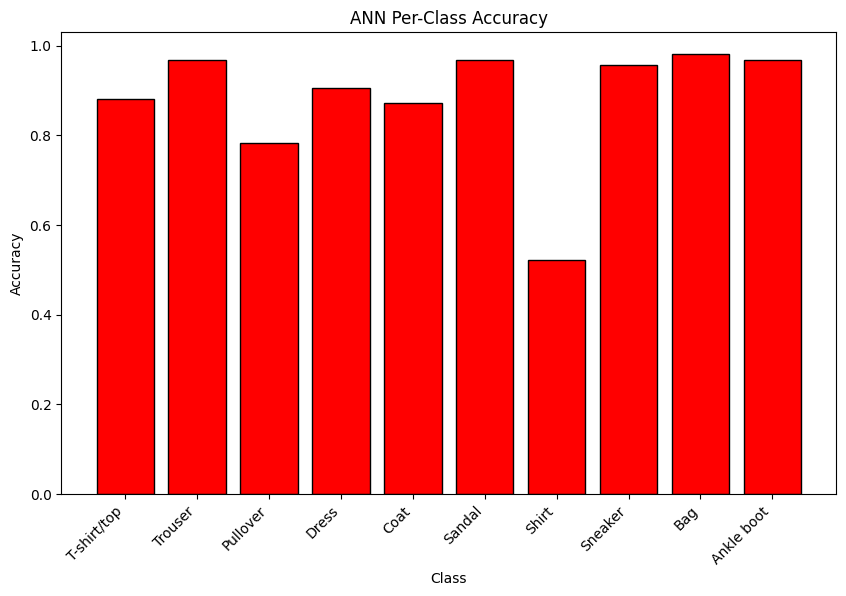

In [61]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

#Get predictions for model
predictions = cnn_model.predict(test_data_cnn)
predicted_labels = np.argmax(predictions, axis=1)

#
cm = confusion_matrix(test_labels, predicted_labels)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt= 'd', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(PLOTS_DIR, 'cnn_confusion_matrix.png'))
plt.show()

print(classification_report(test_labels, predicted_labels, target_names=class_names, digits=4))

# Per-Class Accuracy chart for CNN
per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(10, 6))
plt.bar(class_names, per_class_accuracy, color='yellow', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('CNN Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(PLOTS_DIR, 'cnn_per_class_accuracy.png'))
plt.show()

#Confusion Matrix for ANN
predictions_ann = ann_model.predict(test_data_ann)
predicted_labels = np.argmax(predictions_ann, axis=1)

am = confusion_matrix(test_labels, predicted_labels)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,8))
sns.heatmap(am, annot=True, fmt= 'd', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('ANN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(PLOTS_DIR, 'ann_confusion_matrix.png'))
plt.show()

print(classification_report(test_labels, predicted_labels, target_names=class_names, digits=4))

ann_per_class_accuracy = np.diag(am) / np.sum(am, axis=1)
plt.figure(figsize=(10, 6))
plt.bar(class_names, ann_per_class_accuracy, color='red', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('ANN Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(PLOTS_DIR, 'ann_per_class_accuracy.png'))
plt.show()



**A side-by-side Comparison of ANN and CNN**

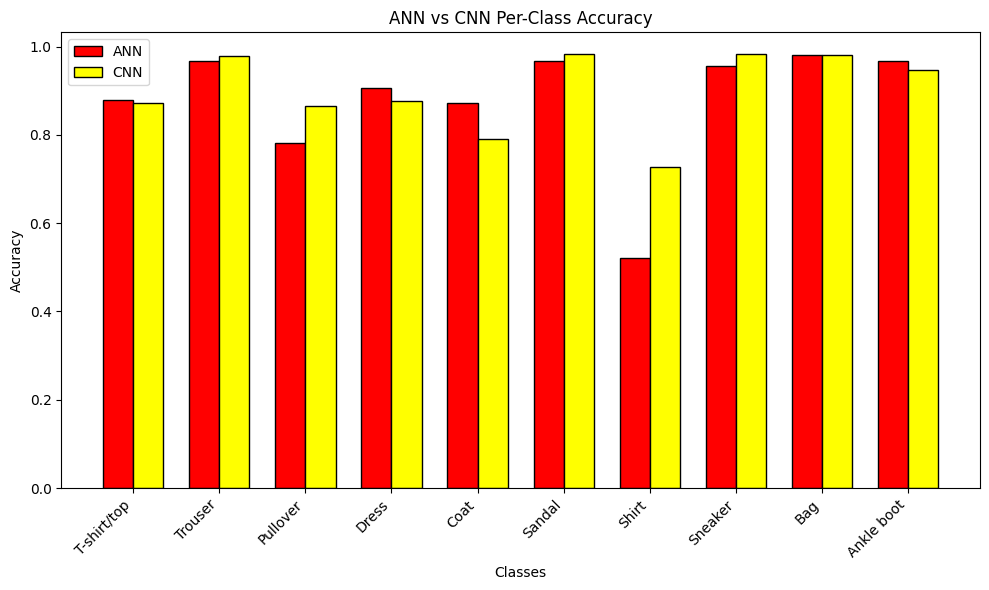

ANN vs CNN Per-Class Accuracy
Class           CNN        ANN        Improvement    
T-shirt/top     0.8720     0.8800     -0.0080        
Trouser         0.9780     0.9680     0.0100         
Pullover        0.8650     0.7820     0.0830         
Dress           0.8760     0.9050     -0.0290        
Coat            0.7900     0.8710     -0.0810        
Sandal          0.9830     0.9680     0.0150         
Shirt           0.7270     0.5210     0.2060         
Sneaker         0.9820     0.9570     0.0250         
Bag             0.9810     0.9810     0.0000         
Ankle boot      0.9470     0.9670     -0.0200        


In [62]:
# Compute per-class accuracy if not already done
per_class_accuracy_ann = np.diag(am) / np.sum(am, axis=1)
per_class_accuracy_cnn = np.diag(cm) / np.sum(cm, axis=1)

x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, per_class_accuracy_ann, width, label='ANN', color='red', edgecolor='black')
plt.bar(x + width/2, per_class_accuracy_cnn, width, label='CNN', color='yellow', edgecolor='black')

plt.xticks(x, class_names, rotation=45, ha='right')
plt.title('ANN vs CNN Per-Class Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

# Save plot
plt.savefig(os.path.join(PLOTS_DIR, 'ann_vs_cnn_per_class_accuracy.png'))
plt.show()

#Detailed comparison
print ("ANN vs CNN Per-Class Accuracy")
print ("=" *60)
print (f"{'Class':<15} {'CNN':<10} {'ANN':<10} {'Improvement':<15}")
print ("=" *60)

for i, class_name in enumerate(class_names):
  print (f"{class_name:<15} {per_class_accuracy_cnn[i]:<10.4f} {per_class_accuracy_ann[i]:<10.4f} {per_class_accuracy_cnn[i] - per_class_accuracy_ann[i]:<15.4f}")
  print ("=" *60)

**Qualitative Evaluation**
A grid of random selected images demonstrates real model behaviour. There would be display of true label, predicted label and confidence probability.
Visual inspection would prove success and failure.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


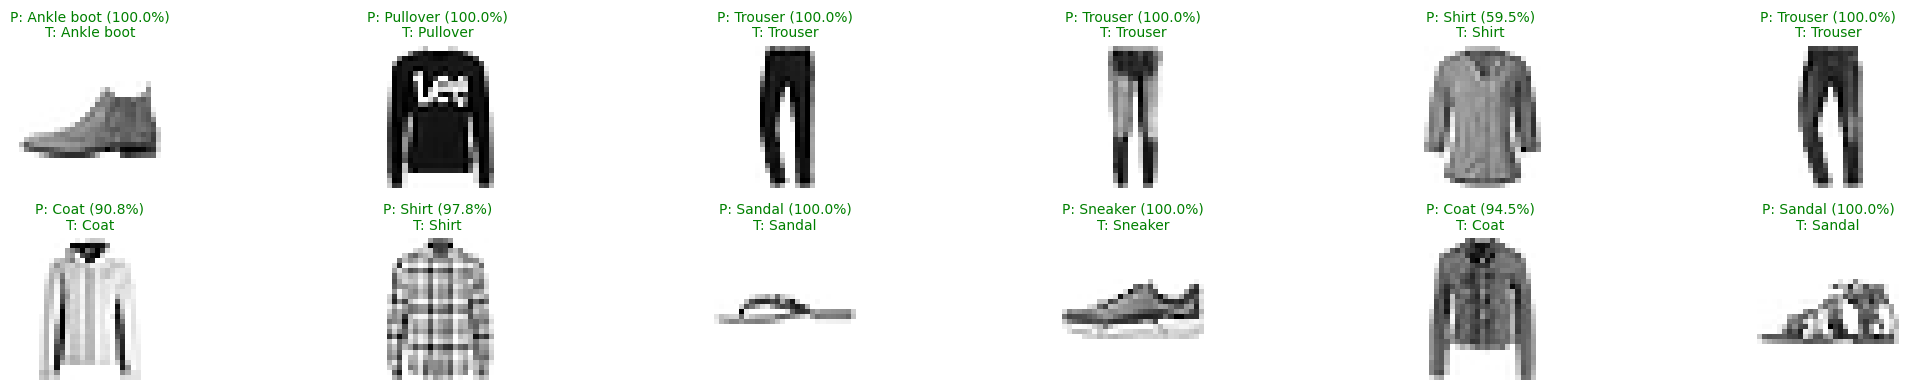

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, predictions, class_names, n=12):
    plt.figure(figsize=(20, 4))

    for i in range(n):
        ax = plt.subplot(2, n//2, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap=plt.cm.binary)

        predicted_label = np.argmax(predictions[i])
        confidence = np.max(predictions[i])
        true_label = labels[i]

        color = 'green' if predicted_label == true_label else 'red'
        plt.title(
            f"P: {class_names[predicted_label]} ({confidence*100:.1f}%)\n"
            f"T: {class_names[true_label]}",
            color=color,
            fontsize=10
        )
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)
    plt.show()

predictions = cnn_model.predict(test_data_cnn)

plot_images(
    test_data_cnn,
    test_labels,
    predictions,
    class_names=[
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ],
    n=12
)
